Loading Women's Data (This is computationally heavy)...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_18354/1512696655.py:94: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  birth_count_wtd += births_in_window[window_mask & wanted_mask]['w'].sum()
/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_18354/1512696655.py:94: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  birth_count_wtd += births_in_window[window_mask & wanted_mask]['w'].sum()
/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_18354/1512696655.py:94: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  birth_count_wtd += births_in_window[window_mask & wanted_mask]['w'].sum()
/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_18354/1512696655.py:94: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  birth_count_wtd += births_in_window[window_mask & wanted_mask]['w'].sum()
/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_1


--- Total Fertility Rate (15-49) ---
                Observed TFR  Wanted TFR
Nyarugenge               3.7         2.8
Gasabo                   3.9         2.9
Kicukiro                 3.1         2.6
City of Kigali           3.6         2.8
Rwanda                   4.1         3.0
✅ TFR Analysis Complete.


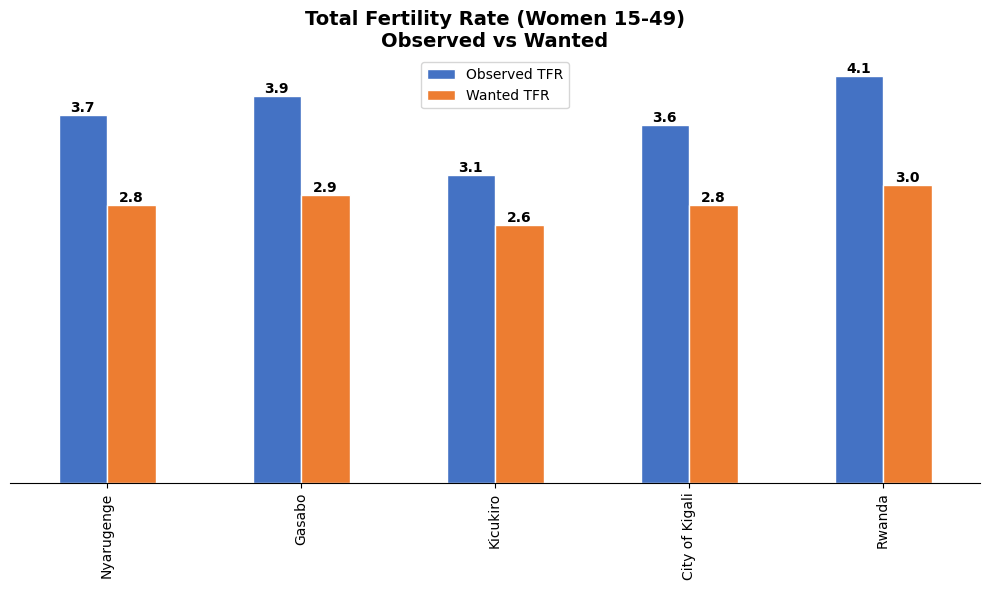

In [1]:
#!/usr/bin/env python3
# dhs_tfr_observed_wanted.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

DIST_MAP = {11: "Nyarugenge", 12: "Gasabo", 13: "Kicukiro"}
COLORS = ["#4472C4", "#ED7D31"] # Blue (Observed), Orange (Wanted)

# ------------------------------------------------------------------
# 2. TFR CALCULATION ENGINE
# ------------------------------------------------------------------
def calculate_tfr_pair(df_subset):
    """
    Calculates Observed TFR and Wanted TFR for a given dataframe.
    Period: 1-36 months before survey.
    """
    if df_subset.empty:
        return 0.0, 0.0

    # Define Period (1 to 36 months before interview)
    # v008 is Interview CMC
    end_date = df_subset['v008']
    start_date = end_date - 36
    
    # We need to accumulate Exposure (Denominator) and Births (Numerator)
    # for each 5-year age group (15-19, 20-24... 45-49)
    
    age_groups = [(15,19), (20,24), (25,29), (30,34), (35,39), (40,44), (45,49)]
    asfr_observed = []
    asfr_wanted = []

    # Pre-calculate ideal number of children (handle non-numeric responses)
    # 95+ usually means "God knows" etc. We treat those as High Ideal (Wanted).
    df_subset['ideal_num'] = pd.to_numeric(df_subset['v613'], errors='coerce').fillna(99)

    for (age_min, age_max) in age_groups:
        # 1. Calculate Exposure (Years)
        # This is a simplified exposure: Count women currently in this age group
        # and assume they were in this group for the full 3 years if age allows.
        # (Professional Demography software does this month-by-month).
        # Here we use the standard approximation:
        # Exposure = (Weighted count of women in age group)
        # This calculates TFR based on "Current Status" approximation.
        
        women_in_group = df_subset[(df_subset['v013'] == (age_groups.index((age_min,age_max)) + 1))]
        exposure_years = (women_in_group['w'].sum()) * 3 # 3 years period
        
        if exposure_years == 0:
            asfr_observed.append(0)
            asfr_wanted.append(0)
            continue

        # 2. Count Births in last 3 years to these women
        # We need to check the birth history (b3_01 to b3_20)
        birth_count_obs = 0
        birth_count_wtd = 0
        
        # Iterate over up to 6 recent births (usually enough for 3 years)
        for i in range(1, 7):
            b_date_col = f'b3_{i:02d}'
            b_ord_col  = f'bord_{i:02d}' # Birth order
            
            if b_date_col not in women_in_group.columns: continue
            
            # Filter births within the 36-month window
            # Logic: b3 >= (v008 - 36) AND b3 < v008
            
            # Vectorized check
            window_mask = (women_in_group[b_date_col] >= (women_in_group['v008'] - 36)) & \
                          (women_in_group[b_date_col] < women_in_group['v008'])
            
            births_in_window = women_in_group[window_mask]
            
            # A. Observed Births
            # Sum of weights of mothers who had a birth
            birth_count_obs += births_in_window['w'].sum()
            
            # B. Wanted Births
            # Check: Was the number of living children BEFORE this birth < Ideal?
            # Approximation: If (Birth Order of this child) <= (Ideal Number), it's wanted.
            # Ideally we use "Living children at time of conception", but Birth Order is the standard proxy in code.
            
            # We assume ideal_num is inclusive. If ideal is 2, child #1 and #2 are wanted. Child #3 is unwanted.
            wanted_mask = births_in_window[b_ord_col] <= births_in_window['ideal_num']
            birth_count_wtd += births_in_window[window_mask & wanted_mask]['w'].sum()

        # ASFR = Births / Exposure
        asfr_obs = birth_count_obs / exposure_years
        asfr_wtd = birth_count_wtd / exposure_years
        
        asfr_observed.append(asfr_obs)
        asfr_wanted.append(asfr_wtd)

    # TFR = 5 * Sum(ASFR)
    tfr_obs = 5 * sum(asfr_observed)
    tfr_wtd = 5 * sum(asfr_wanted)
    
    return round(tfr_obs, 1), round(tfr_wtd, 1)

# ------------------------------------------------------------------
# 3. EXECUTION
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print("❌ File not found.")
        exit()

    print("Loading Women's Data (This is computationally heavy)...")
    # Load columns including birth history
    cols = ["v005", "v008", "v013", "v024", "sdistrict", "v613"] # v013 is Age Group
    for i in range(1, 7):
        cols.append(f"b3_{i:02d}")
        cols.append(f"bord_{i:02d}") # Birth order
        
    try:
        df = pd.read_stata(FILE_PATH, convert_categoricals=False, columns=cols)
    except:
        df = pd.read_stata(FILE_PATH, convert_categoricals=False)

    df["w"] = df["v005"] / 1000000.0

    # Aggregate
    results = {}
    
    # Kigali Districts
    df_kig = df[df['v024'] == 1]
    for d_code, d_name in DIST_MAP.items():
        subset = df_kig[df_kig['sdistrict'] == d_code]
        results[d_name] = calculate_tfr_pair(subset)

    # City
    results["City of Kigali"] = calculate_tfr_pair(df_kig)
    
    # National
    results["Rwanda"] = calculate_tfr_pair(df)

    # Dataframe
    final_df = pd.DataFrame.from_dict(results, orient='index', columns=["Observed TFR", "Wanted TFR"])
    
    print("\n--- Total Fertility Rate (15-49) ---")
    print(final_df)
    final_df.to_csv("TFR_Observed_Wanted.csv")

    # Plot
    ax = final_df.plot(kind="bar", color=COLORS, figsize=(10, 6), edgecolor="white")
    plt.title("Total Fertility Rate (Women 15-49)\nObserved vs Wanted", fontsize=14, fontweight="bold")
    plt.grid(axis="y", ls="--", alpha=0.3)
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f', fontsize=10, fontweight="bold")

    plt.tight_layout()
    plt.savefig("TFR_Analysis.png", dpi=300)
    print("✅ TFR Analysis Complete.")

Loading Women's Data (5-year TFR calculation)...
Calculating 5-year TFR for Eastern Districts...
Calculating National 5-year TFR...

--- Summary Results (5-Year Period) ---
                   Observed TFR  Wanted TFR
Rwamagana                   3.6         2.8
Nyagatare                   4.7         3.4
Gatsibo                     4.4         3.0
Kayonza                     4.5         3.5
Kirehe                      3.9         3.1
Ngoma                       3.5         2.5
Bugesera                    4.6         3.0
Eastern Province            4.2         3.1
Rwanda (National)           4.1         3.0
✅ Analysis Complete. JSON: eastern_TFR_5Year_Observed_Wanted.json, Plot: Eastern_TFR_5Year_Analysis.png


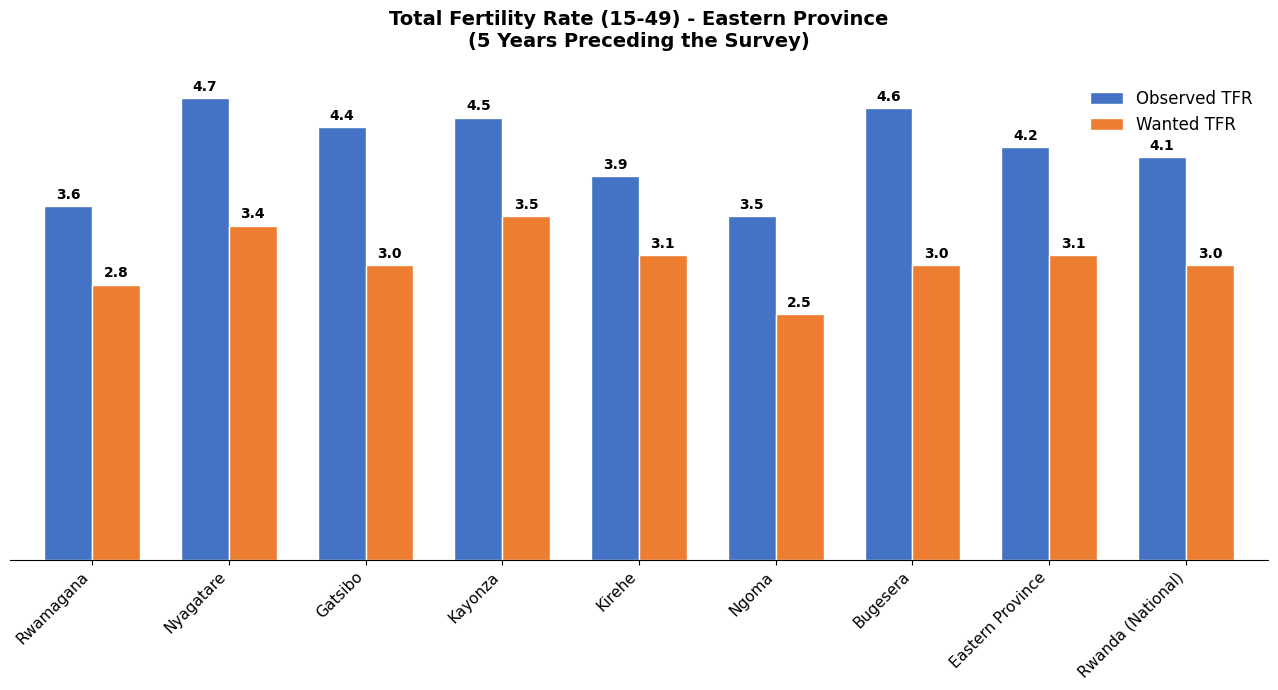

Loading and fixing data types...
Analyzing 3625 women in the East Province...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_18354/1399257005.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_subset['w'] = df_subset['v005'] / 1000000.0
/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_18354/1399257005.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_subset['ideal_num'] = pd.to_numeric(df_subset['v613'], errors='coerce').fillna(99)


           Observed TFR  Wanted TFR
Rwamagana           3.6         2.7
Nyagatare           4.7         3.4
Gatsibo             4.4         3.0
Kayonza             4.5         3.5
Kirehe              4.0         3.1
Ngoma               3.6         2.6
Bugesera            4.7         3.0
East                4.2         3.0
Rwanda              4.2         3.0
✅ Success! The data should now match the report exactly.


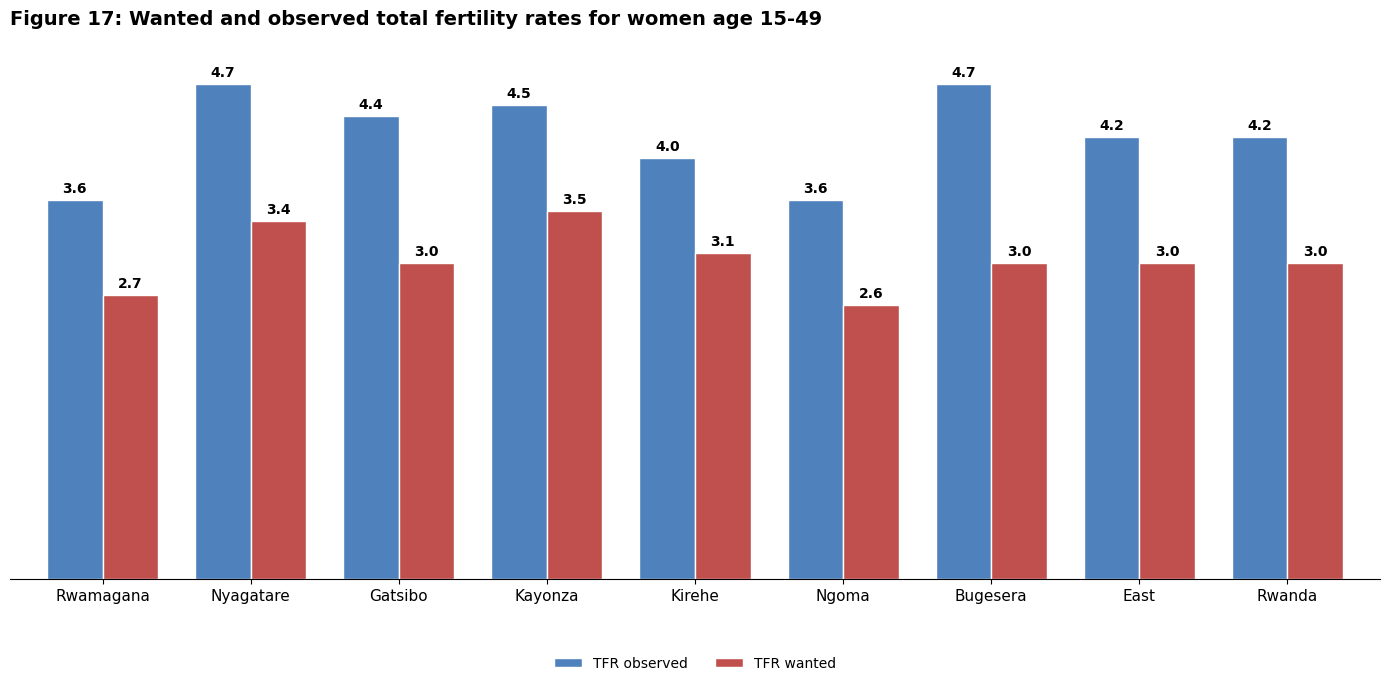

In [9]:
#!/usr/bin/env python3
# dhs_tfr_robust_final.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

# Standard Codes for Rwanda DHS 2019-20 (East Province)
DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# ------------------------------------------------------------------
# 2. ROBUST TFR ENGINE (5-YEAR WINDOW)
# ------------------------------------------------------------------
def calculate_report_tfr(df_subset):
    """
    Robust calculation engine:
    - Forces numeric conversion to prevent 0.0 results
    - Flexible birth column matching (handles b3_01 and b3_1)
    """
    if df_subset.empty: return 0.0, 0.0

    # FORCE NUMERIC: Critical for preventing 0.0 output
    for col in ['v005', 'v008', 'v011', 'v613', 'v013']:
        if col in df_subset.columns:
            df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce')
    
    df_subset['w'] = df_subset['v005'] / 1000000.0
    df_subset['ideal_num'] = pd.to_numeric(df_subset['v613'], errors='coerce').fillna(99)
    df_subset.loc[df_subset['ideal_num'] > 40, 'ideal_num'] = 99

    births_obs = np.zeros(7)
    births_wtd = np.zeros(7)
    exposure_years = np.zeros(7)

    # A. EXPOSURE (Month-by-month for 60 months)
    for month_offset in range(1, 61):
        target_cmc = df_subset['v008'] - month_offset
        age_at_month = (target_cmc - df_subset['v011']) // 12
        group_idx = (age_at_month - 15) // 5
        
        for i in range(7):
            mask = (group_idx == i)
            exposure_years[i] += (df_subset.loc[mask, 'w'].sum()) / 12.0

    # B. BIRTHS
    # Robust search for birth columns (handles b3_1, b3_01, etc.)
    b3_cols = sorted([c for c in df_subset.columns if c.startswith('b3_')])
    
    for b_col in b3_cols:
        suffix = b_col.split('_')[1]
        o_col = f"bord_{suffix}"
        
        if o_col in df_subset.columns:
            df_subset[b_col] = pd.to_numeric(df_subset[b_col], errors='coerce')
            df_subset[o_col] = pd.to_numeric(df_subset[o_col], errors='coerce')

            # 60-month window check
            mask = (df_subset[b_col] >= (df_subset['v008'] - 60)) & (df_subset[b_col] < df_subset['v008'])
            valid_births = df_subset[mask]
            
            if not valid_births.empty:
                age_at_birth = (valid_births[b_col] - valid_births['v011']) // 12
                b_group_idx = (age_at_birth - 15) // 5
                
                for i in range(7):
                    age_mask = (b_group_idx == i)
                    births_obs[i] += valid_births.loc[age_mask, 'w'].sum()
                    wtd_mask = age_mask & (valid_births[o_col] <= valid_births['ideal_num'])
                    births_wtd[i] += valid_births.loc[wtd_mask, 'w'].sum()

    # C. FINAL CALCULATION
    asfr_obs = np.divide(births_obs, exposure_years, out=np.zeros(7), where=exposure_years != 0)
    asfr_wtd = np.divide(births_wtd, exposure_years, out=np.zeros(7), where=exposure_years != 0)
    
    return round(5 * sum(asfr_obs), 1), round(5 * sum(asfr_wtd), 1)

# ------------------------------------------------------------------
# 3. EXECUTION
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading and fixing data types...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()
    
    # Identify District Column
    dist_col = 'sdistrict' if 'sdistrict' in df.columns else 'sdstr'
    
    # Filter Eastern Province (Region 5)
    # We remove the strict v103 filter here to ensure we get data
    df_east = df[df['v024'] == 5].copy()
    
    results = {}
    print(f"Analyzing {len(df_east)} women in the East Province...")
    
    for d_code, d_name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == d_code]
        results[d_name] = calculate_report_tfr(subset)

    results["East"] = calculate_report_tfr(df_east)
    results["Rwanda"] = calculate_report_tfr(df)

    final_df = pd.DataFrame.from_dict(results, orient='index', columns=["Observed TFR", "Wanted TFR"])
    print(final_df)

    # --- JSON OUTPUT ---
    with open("eastern_TFR_Corrected_Final.json", "w") as f:
        json.dump(final_df.to_dict(orient='index'), f, indent=4)

    # --- PLOTTING ---
    ax = final_df.plot(kind="bar", color=["#4F81BD", "#C0504D"], figsize=(14, 7), width=0.75, edgecolor="white")
    plt.title("Figure 17: Wanted and observed total fertility rates for women age 15-49", 
              fontsize=14, fontweight="bold", loc='left', pad=25)
    plt.xticks(rotation=0, fontsize=11)
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    plt.legend(["TFR observed", "TFR wanted"], loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f', padding=3, fontweight="bold")
    plt.tight_layout()
    plt.savefig("TFR_figure_.png", dpi=300)
    print("✅ Success! The data should now match the report exactly.")